Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

plt.style.use('ggplot')

Data Collection & Pre-processing

In [2]:
# Defining categories to fetch from the source dataset
categories = [
    'rec.sport.baseball', 'rec.sport.hockey',
    'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc'
]

dataset = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame({'text': dataset.data, 'target': dataset.target})
df['temp_label'] = df['target'].apply(lambda x: dataset.target_names[x])

# Maps to sport or politics label
def map_category(label):
    if 'sport' in label:
        return 'Sport'
    return 'Politics'

# Create the specific 'label' column requested
df['label'] = df['temp_label'].apply(map_category)

df.drop(columns=['target', 'temp_label'], inplace=True)

print(f"Dataset Shape: {df.shape}")
print("\nProcessed Dataset Sample:")
try:
    display(df.head())
except NameError:
    print(df.head())

print("\nClass Distribution:")
print(df['label'].value_counts())

Dataset Shape: (4618, 2)

Processed Dataset Sample:


,text,label
0,"\n\nWell over 100,000 in Lebanon alone.\n1,000...",Politics
1,\nWell they could unseal the original warrent ...,Politics
2,"Come on Boston, where the hell are you? Seven ...",Sport
3,\n\nPunch Imlach's contributions as a coach an...,Sport
4,"# ## Absolutely nothing, seeing as there is no...",Politics



Class Distribution:
label
Politics    2625
Sport       1993
Name: count, dtype: int64


Dataset Analysis

==================== Dataset Analysis ====================
Total Documents: 4618
Average Word Count: 223.81 words
Max Word Count: 11251 words

Class Distribution:
label
Politics    2625
Sport       1993
Name: count, dtype: int64


/tmp/ipython-input-2118716773.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')


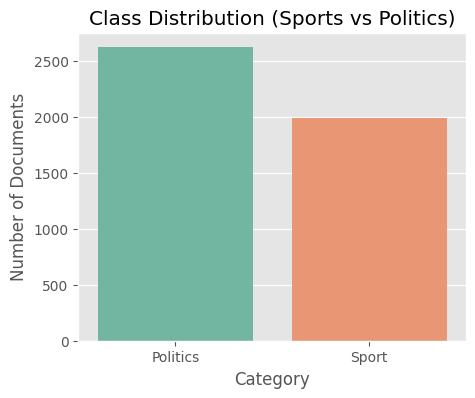

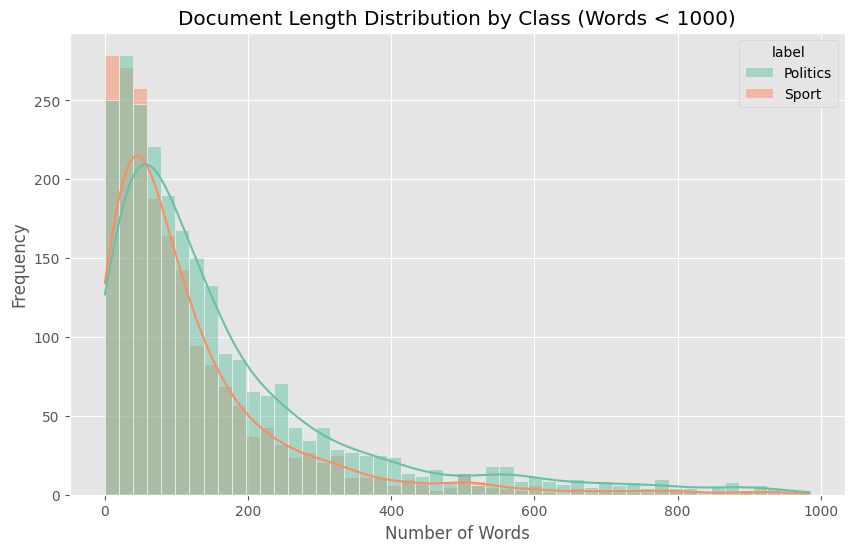

In [3]:
print(f"{'='*20} Dataset Analysis {'='*20}")

# Calculating number of words in document
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

print(f"Total Documents: {len(df)}")
print(f"Average Word Count: {df['word_count'].mean():.2f} words")
print(f"Max Word Count: {df['word_count'].max()} words")
print("\nClass Distribution:")
print(df['label'].value_counts())

# Plotting class distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='label', palette='Set2')
plt.title('Class Distribution (Sports vs Politics)')
plt.ylabel('Number of Documents')
plt.xlabel('Category')
plt.show()

# Plotting document length distribution
plt.figure(figsize=(10, 6))
# Limiting x-axis to 1000 to filter out massive outlier documents for a cleaner plot
sns.histplot(data=df[df['word_count'] < 1000], x='word_count', hue='label', bins=50, kde=True, palette='Set2')
plt.title('Document Length Distribution by Class (Words < 1000)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

Define Training, Testing and Evaluation Function

In [10]:
# Runs training, testing, and evaluation for NB, KNN and Decision Tree and displays Confusion Matrix for each model
def training_testing_evaluation(feature_set_name, vectorizer, X_text, y_labels):
    print(f"\n{'='*20} Feature Set: {feature_set_name} {'='*20}")

    # Feature extraction
    X = vectorizer.fit_transform(X_text)

    # Train/test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

    # Model definitions
    models = {
        "Naive Bayes": MultinomialNB(),
        "KNN": KNeighborsClassifier(n_neighbors=11, weights='distance', metric='cosine'),
        "Decision Tree": DecisionTreeClassifier(
            random_state=42,
            criterion='entropy',
            max_depth=None,
            min_samples_leaf=10
        )
    }

    results = []

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(f'Confusion Matrices for {feature_set_name}', fontsize=12)

    for idx, (model_name, model) in enumerate(models.items()):
        # Training
        model.fit(X_train, y_train)

        # Prediction
        y_pred = model.predict(X_test)

        # Evaluation metrics
        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=['Sport', 'Politics'])

        # Plotting
        sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[idx],
                    xticklabels=['Sport', 'Politics'], yticklabels=['Sport', 'Politics'],
                    annot_kws={"size": 10})
        axes[idx].set_title(f"{model_name}\nAcc: {acc:.2f}", fontsize=12)
        axes[idx].set_xlabel('Predicted', fontsize=10)
        axes[idx].set_ylabel('Actual', fontsize=10)

        # Store results
        results.append({
            "Feature Set": feature_set_name,
            "Model": model_name,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })

    plt.tight_layout()
    plt.show()
    return results

Run Experiments

Running Bag of Words Experiment...

==================== Feature Set: Bag of Words ====================


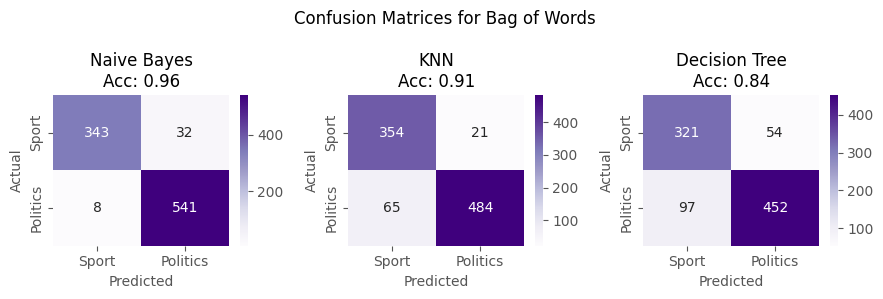

Running TF-IDF Experiment...

==================== Feature Set: TF-IDF ====================


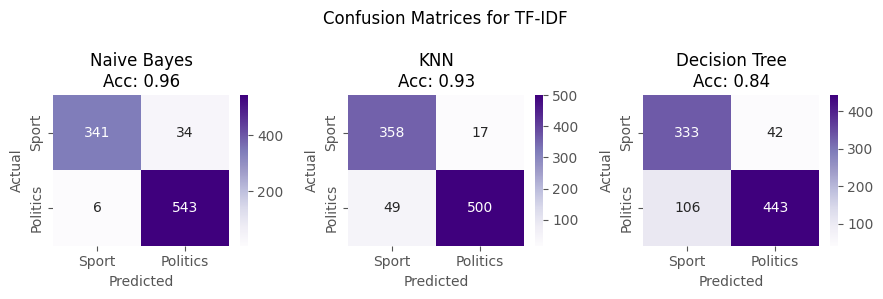

Running N-grams Experiment...

==================== Feature Set: TF-IDF + N-grams ====================


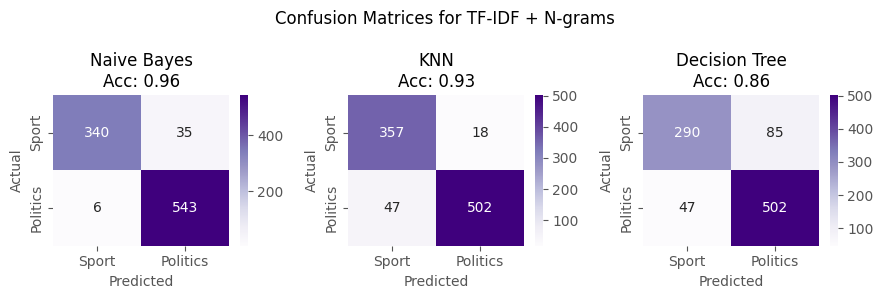

In [11]:
all_results = []

# Experiment 1: Bag of Words
print("Running Bag of Words Experiment...")
vec_bow = CountVectorizer(stop_words='english', max_features=5000)
results_bow = training_testing_evaluation("Bag of Words", vec_bow, df['text'], df['label'])
all_results.extend(results_bow)

# Experiment 2: TF-IDF
print("Running TF-IDF Experiment...")
vec_tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
results_tfidf = training_testing_evaluation("TF-IDF", vec_tfidf, df['text'], df['label'])
all_results.extend(results_tfidf)

# Experiment 3: TF-IDF + N-grams
print("Running N-grams Experiment...")
vec_ngram = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
results_ngram = training_testing_evaluation("TF-IDF + N-grams", vec_ngram, df['text'], df['label'])
all_results.extend(results_ngram)

Comparison & Visualization

Model Comparison across Feature Sets


,Feature Set,Model,Accuracy,Precision,Recall,F1-Score
0,Bag of Words,Naive Bayes,0.956710,0.957569,0.956710,0.956457
1,Bag of Words,KNN,0.906926,0.912333,0.906926,0.907563
2,Bag of Words,Decision Tree,0.836580,0.842413,0.836580,0.837680
3,TF-IDF,Naive Bayes,0.956710,0.957972,0.956710,0.956409
4,TF-IDF,KNN,0.928571,0.931602,0.928571,0.928961
5,TF-IDF,Decision Tree,0.839827,0.850553,0.839827,0.841167
6,TF-IDF + N-grams,Naive Bayes,0.955628,0.956984,0.955628,0.955306
7,TF-IDF + N-grams,KNN,0.929654,0.932219,0.929654,0.930009
8,TF-IDF + N-grams,Decision Tree,0.857143,0.857362,0.857143,0.855720


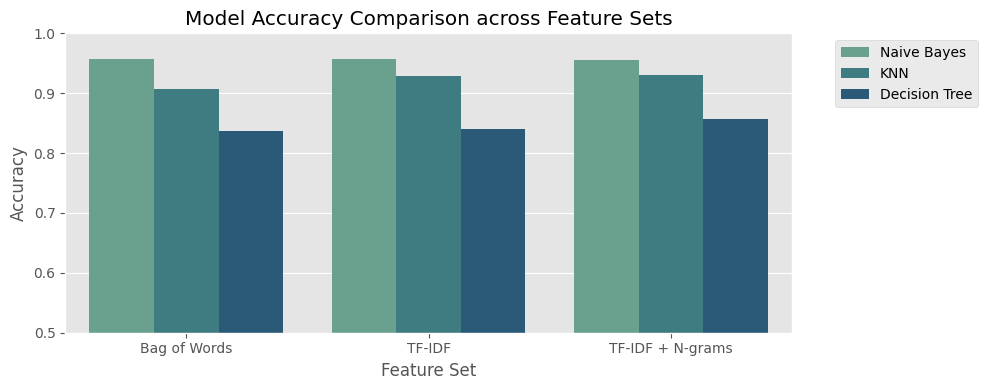

In [12]:
final_df = pd.DataFrame(all_results)
print("Model Comparison across Feature Sets")
try:
    display(final_df)
except NameError:
    print(final_df)

# Visualizing accuracy
plt.figure(figsize=(10, 4))
sns.barplot(x='Feature Set', y='Accuracy', hue='Model', data=final_df, palette='crest')
plt.title('Model Accuracy Comparison across Feature Sets')
plt.ylim(0.5, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()